In [4]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import h5py
from read_O3_LVK_results import *
from scipy.special import erf
from scipy.optimize import minimize

In [3]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_chi_cost_summary.hdf","r")
chis = precomputed_data['posterior/chis'][()]
costs = precomputed_data['posterior/costs'][()]
dR_dchis = precomputed_data['posterior/dR_dchis'][()]
dR_dcosts = precomputed_data['posterior/dR_dcosts'][()]
f_chis = precomputed_data['posterior/f_chis'][()]
f_costs = precomputed_data['posterior/f_costs'][()]

## 1. Fit toy parametric models to our AR results

In [9]:
# Define a few parameteric distributions that might provide good fits to our results
def truncatedNormal(x,mu,sig):
    
    """
    Helper function definind truncated normal distribution on the interval (0,1)
    
    Parameters
    ----------
    x : Location to evaluate truncated normal
    mu : Mean parameter
    sig : Standard deviation parameter
    """
    
    norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((0.-mu)/np.sqrt(2.*sig**2)))
    return np.exp(-(x-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/norm

def lorentzian(x,mu,gamma):
    
    """
    Helper function defining a Lorentzian probability distribution
    
    Parameters
    ----------
    x : Location to evaluate Lorentzian
    mu : Mean parameter
    gamma : Width parameter
    """
    
    norm = (np.arctan((1.-mu)/gamma) - np.arctan((0.-mu)/gamma))/np.pi
    return (1./(np.pi*gamma))*1./(1.+((x-mu)/gamma)**2)/norm

def cost_mixture(u,f_iso,mu,sig):
    
    """
    Helper function defining a mixture between isotropic and gaussian components
    
    Parameters
    ----------
    u : Location to evaluate mixture model
    f_iso : Mixture fraction of the isotropic component
    mu : Mean of the gaussian component
    sig : Standard deviation of the gaussian component
    """
    
    p_iso = 0.5*np.ones_like(u)
    p_gaussian_norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((-1.-mu)/np.sqrt(2.*sig**2)))
    p_gaussian = np.exp(-(u-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/p_gaussian_norm
    
    return  p_iso*f_iso + p_gaussian*(1.-f_iso)

# We'll perform our least-squares fit to the spin magnitude and cos-tilt PPDs
p_chi = f_chis/np.trapz(f_chis,chis,axis=0)
p_cost = f_costs/np.trapz(f_costs,costs,axis=0)
p_chi_target = np.mean(p_chi,axis=1)
p_cost_target = np.mean(p_cost,axis=1)

# Define least-squares loss functions for each of our models
def ls_gaussian(params):

    mu,sig = params
    p_chi_model = truncatedNormal(chis,mu,sig)

    return np.trapz((p_chi_model-p_chi_target)**2,chis)

def ls_lorentzian(params):
    
    mu,gamma = params
    p_chi_model = lorentzian(chis,mu,gamma)
    
    return np.trapz((p_chi_model-p_chi_target)**2,chis)

def ls_costs(params):
    
    f_iso,u_mu,u_sig = params
    p_cost_model = cost_mixture(costs,f_iso,u_mu,u_sig)
    
    return np.trapz((p_cost_model-p_cost_target)**2,costs)

# Define some reasonable initial guesses for our various parametric models
gaussian_mu = 0.04
gaussian_sig = 0.3
lorentzian_mu = 0.1
lorentzian_gamma = 0.3
cost_mixture_f_iso = 0.7
cost_mixture_mu = 0.45
cost_mixture_sig = 0.5

initial_params_gaussian = (gaussian_mu,gaussian_sig)
gaussian_soln = minimize(ls_gaussian,
                         initial_params_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_lorentzian = (lorentzian_mu,lorentzian_gamma)
lorentzian_soln = minimize(ls_lorentzian,
                         initial_params_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_cost = (cost_mixture_f_iso,cost_mixture_mu,cost_mixture_sig)
cost_soln = minimize(ls_costs,
                         initial_params_cost,
                         method='Nelder-Mead',
                         options={'maxiter':1e5})

print(gaussian_soln.success,gaussian_soln.x)
print(lorentzian_soln.success,lorentzian_soln.x)
print(cost_soln.success,cost_soln.x)

True [0.         0.32194284]
True [0.08891181 0.244716  ]
True [0.60818889 0.56071461 0.63157995]


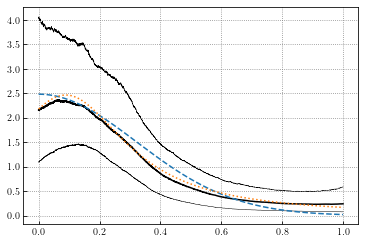

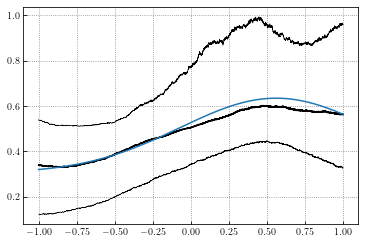

In [16]:
# Plot our best-fit parameters to make sure things look reasonable

###################################
# Set up figure for spin magnitudes
###################################

fig,ax = plt.subplots(figsize=(6,4))

# Plot our AR results
ax.plot(chis,np.quantile(p_chi,0.05,axis=1),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.95,axis=1),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.5,axis=1),color='black')

gaussian_fit = truncatedNormal(chis,*gaussian_soln.x)
ax.plot(chis,gaussian_fit,ls='--')

lorentzian_fit = lorentzian(chis,*lorentzian_soln.x)
ax.plot(chis,lorentzian_fit,ls=':')

plt.show()

###################################
# Set up figure for spin tilts
###################################

fig,ax = plt.subplots(figsize=(6,4))

# Plot AR results
ax.plot(costs,np.quantile(p_cost,0.05,axis=1),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.95,axis=1),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.5,axis=1),color='black')

mixture_fit = cost_mixture(costs,*cost_soln.x)
ax.plot(costs,mixture_fit)

plt.show()

In [19]:
# Save our fitting results

gaussian_mean,gaussian_std = gaussian_soln.x
lorentzian_mean,lorentzian_gamma = lorentzian_soln.x
f_iso,cost_mu,cost_sig = cost_soln.x

with open('./../macros/fitting_results_component_spins.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\MagFitGaussianMean}}{{{0:.2f}}}".format(gaussian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MagFitGaussianStd}}{{{0:.2f}}}".format(gaussian_std))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MagFitLorentzianMean}}{{{0:.2f}}}".format(lorentzian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MagFitLorentzianGamma}}{{{0:.2f}}}".format(lorentzian_gamma))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\CosTiltFitFractionIso}}{{{0:.2f}}}".format(f_iso))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\CosTiltFitMean}}{{{0:.2f}}}".format(cost_mu))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\CosTiltFitStd}}{{{0:.2f}}}".format(cost_sig))
    macrofile.write("\n")

## 2. Plot AR results, LVK results, and our parametric fit

In [20]:
# Read out LVK inference results
lvk_chi_grid,lvk_cost_grid,lvk_R_chi,lvk_R_cost,lvk_p_chis,lvk_p_costs = get_lvk_componentSpin(500)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

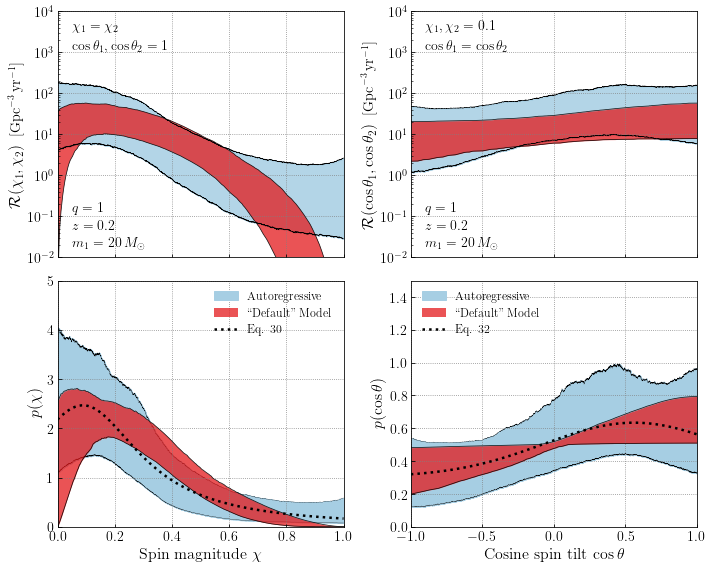

In [32]:
############################################
# Figure for merger rates vs. spin magnitude
############################################

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
# Plot AR results
ax.plot(chis,np.quantile(dR_dchis,0.05,axis=1),color='black',lw=0.5)
ax.plot(chis,np.quantile(dR_dchis,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(chis,
                np.quantile(dR_dchis,0.05,axis=1),
                np.quantile(dR_dchis,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

# Plot LVK parametric fit
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_R_chi,0.05,axis=0),
                np.quantile(lvk_R_chi,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}(\chi_1,\chi_2)$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

# Annotate with reference values
ax.text(0.05,0.94,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.86,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)


############################################
# Figure for merger rates vs. spin tilts
############################################

ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

# AR results
ax.plot(costs,np.quantile(dR_dcosts,0.05,axis=1),color='black',lw=0.5)
ax.plot(costs,np.quantile(dR_dcosts,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(costs,
                np.quantile(dR_dcosts,0.05,axis=1),
                np.quantile(dR_dcosts,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

# LVK results
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_R_cost,0.05,axis=0),
                np.quantile(lvk_R_cost,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}(\cos\theta_1,\cos\theta_2)$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

# Annotate with reference quantitities
ax.text(0.05,0.94,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.86,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

################################################
# Probability distribution over spin magnitudes
################################################

ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

# AR results
ax.plot(chis,np.quantile(p_chi,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(chis,np.quantile(p_chi,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(chis,
                np.quantile(p_chi,0.05,axis=1),
                np.quantile(p_chi,0.95,axis=1),
                label='Autoregressive',
                color='#a6cee3',alpha=1,zorder=-1)

# LVK results
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_p_chis,0.05,axis=0),
                np.quantile(lvk_p_chis,0.95,axis=0),
                label=r"``Default'' Model",
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

# Parameteric lorentzian fit
ax.plot(chis,lorentzian(chis,*lorentzian_soln.x),color='black',ls=':',lw=2.5,label='Eq. 30')

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=16)
ax.legend(loc='upper right',frameon=False)

################################################
# Probability distribution over spin tilts
################################################

ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

# AR results
ax.plot(costs,np.quantile(p_cost,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(costs,np.quantile(p_cost,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(costs,
                np.quantile(p_cost,0.05,axis=1),
                np.quantile(p_cost,0.95,axis=1),
                label='Autoregressive',
                color='#a6cee3',alpha=1,zorder=-1)

# LVK
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_p_costs,0.05,axis=0),
                np.quantile(lvk_p_costs,0.95,axis=0),
                label=r"``Default'' Model",
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

# Parametric fit
ax.plot(costs,cost_mixture(costs,*cost_soln.x),color='black',ls=':',lw=2.5,label='Eq. 32')

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)
ax.set_ylabel(r'$p(\cos\theta)$',fontsize=16)
ax.legend(loc='upper left',frameon=False)

plt.tight_layout()
plt.savefig('figure_11.pdf',bbox_inches='tight',dpi=200)
plt.show()